In [1]:
# Import necessary modules
from scipy.integrate import odeint  
import numpy as np
from matplotlib import pyplot as plt

<div> <img src="Flow diagram.png" alt="Drawing" style="width: 800px;"/></div> 

Rate constants:

* km: rate constant of mRNA production - depends on affinity to promoter - how likely that promoter is to be transcribed so an mRNA molecule is produced
* kdm: rate of mRNA loss (cause mRNA get broken down/isn't stable)
* kp: rate at which mRNA is traslated
* kdp: rate at which protein is lost (degraded for whatever reason)
* **ku**: rate of urea import (different from Basic Bathub because in that case ku included urea import and urease reaction until the formation of CO3; here it includes urea import and H2CO3 formation).
* **kco2_in_u**: Rate at which H2CO3 spontaneously disassociates into CO2 and H20
* **kco2_out_u**: Rate at which CO2 and H20 spontaneously associate into H2CO3
* **kco2_in**: Rate at which CO2 comes into the cell
* **kco2_out**: Rate at which CO2 leaves the cell
* **kass**: Rate of CA (Carbonic Anhydrase) and CO2 association to form enzyme complex
* **kdiss**: Rate of enzyme complex dissociation to form CA and CO2
* **kCA**: Rate at which CA produces H2CO3
* **kion**: Rate at which H2CO3 spontaneously ionises into CO3 and H+ (includes reversibility, so CO3 and H into H2CO3)
* kxco: rate at which CO3 binds to something other than Ca (that CO3 is not longer available for binding to Ca)
* kcaco: rate at which CO3 binds to Ca

Values:

* M1 = urease mRNA copy number
* M2 = CA mRNA copy number
* U = number of urease enzymes
* CA = number of CA enzymes
* H2CO3 = number of H2CO3 molecules
* CO2 = number of CO2 molecules
* CA_CO2 = number of CA and CO2 enzyme complexes formed
* CO3 = number of CO3 molecules
* CaCO3 = number of CaCO3 molcules

In [15]:
# define sdot deterministic bath tub
def sdot_det_com_bathtub(s,t,params):
    M1, M2, U, CA, H2CO3, CO2, CA_CO2, CO3, CaCO3, Ca, X = s
    km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, ku, kco2_in_u, kco2_out_u, kco2_in, kco2_out, kass, kdiss, kCA, kion, kxco, kco = params
    
    
    # mRNA Levels
    ## urease mRNA
    rate_M1_production = km1 * 1 #there's 1 copy of the urease gene
    rate_M1_loss = kdm1 * M1
    
    dM1 = rate_M1_production - rate_M1_loss
    
    ## CA mRNA
    rate_M2_production = km2 * 1 #there's 1 copy of the CA gene
    rate_M2_loss = kdm1 * M2
    
    dM2 = rate_M2_production - rate_M2_loss
    
    
    
    # Protein levels
    ## Urease 
    rate_U_production = kp1 * M1 
    rate_U_loss = kdp1 * U
    
    dU = rate_U_production - rate_U_loss
    
    ## CA
    rate_CA_production = kp2 * M2 
    rate_CA_loss = kdp2 * CA
    
    dCA = rate_CA_production - rate_CA_loss
    
    
    
    # H2CO3 levels
    rate_H2CO3_production = ku*U + kco2_out_u*CO2 + kCA*CA_CO2
    rate_H2CO3_loss = kco2_in_u*H2CO3 # - kion*H2CO3
    
    dH2CO3 = rate_H2CO3_production - rate_H2CO3_loss
    
    
    
    #CO2 levels
    rate_CO2_production = kco2_in_u*H2CO3 + kco2_in + kdiss*CA_CO2
    rate_CO2_loss = kco2_out_u*CO2 + kco2_out*CO2 + kass*CO2*CA
    
    dCO2 = rate_CO2_production - rate_CO2_loss
    
    
    
    #CA & CO2 enzyme complex levels
    rate_forward = kass*CA*CO2
    rate_backward = kdiss*CA_CO2
    rate_enz_action = kCA*CA_CO2
    
    dCA_CO2 = rate_forward - rate_backward - rate_enz_action

     
    
    #CO3 production
    rate_CO3_production = kion * H2CO3 #urea influx times urease copy number
    
    rate_CO3_loss_XCO3 = kxco*X*CO3  #lose CO3 when it binds to other stuff
    rate_CO3_loss_CaCO3 = kco*Ca*CO3 #will lose CO3 when ir binds to Ca
    rate_CO3_loss = rate_CO3_loss_XCO3 + rate_CO3_loss_CaCO3
    
    dCO3 = rate_CO3_production - rate_CO3_loss
        
    dX = -kxco*X*CO3 #X gets used up and isnt't replaced   
    
    
    
    ##CaC03 production
    dCa = -kco*Ca*CO3   #Calcium gets used up and isn't replaced
    dCaCO3 = kco*Ca*CO3   # assume that CaCO3 isn't lost once formed. Assume that even as Ca is used up, rate
                          # of reaction doesn't change - not entirely true, the less Ca molecules, the harder it will be for 
                          # them to find CO3
    
    
    
    dsdt = [dM1, dM2, dU, dCA, dH2CO3, dCO2, dCA_CO2, dCO3, dCaCO3, dCa, dX]
    
    return dsdt

In [16]:
#Note: numbers are made up
km1 = 20
km2 = 20
kdm1 = 0.1386
kdm2 = 0.1386 
kp1 = 480
kp2 =  480
kdp1 = 0.0166
kdp2 = 0.0166
ku = 3
kco2_in_u = 0.7
kco2_out_u = 0.4
kco2_in = 2
kco2_out = 1.8
kass = 0.2
kdiss = 0.12
kCA = 7
kion = 0.8
kxco = 0.005
kco = 0.001

params = [km1, km2, kdm1, kdm2, kp1, kp2, kdp1, kdp2, ku, kco2_in_u,
          kco2_out_u, kco2_in, kco2_out, kass, kdiss, kCA, kion, kxco, kco]

In [17]:
M1= 10 #let's say that we start with 10 copy of the mRNA
M2 = 5
U = 1e3 
CA = 1e2
H2CO3 = 0
CO2 = 1e4
CA_CO2 = 0
CO3 = 0
CaCO3 = 0
Ca = 1e10
X = 2e10


s0 = [M1, M2, U, CA, H2CO3, CO2, CA_CO2, CO3, CaCO3, Ca, X]

In [18]:
t_start = 0
t_end = 1000
n_obs = 100000  #Equivalent of how many measurements you want to take
t_obs = np.linspace(t_start, t_end, n_obs)

In [19]:
s_obs = odeint(sdot_det_com_bathtub, s0, t_obs, args=(params,))

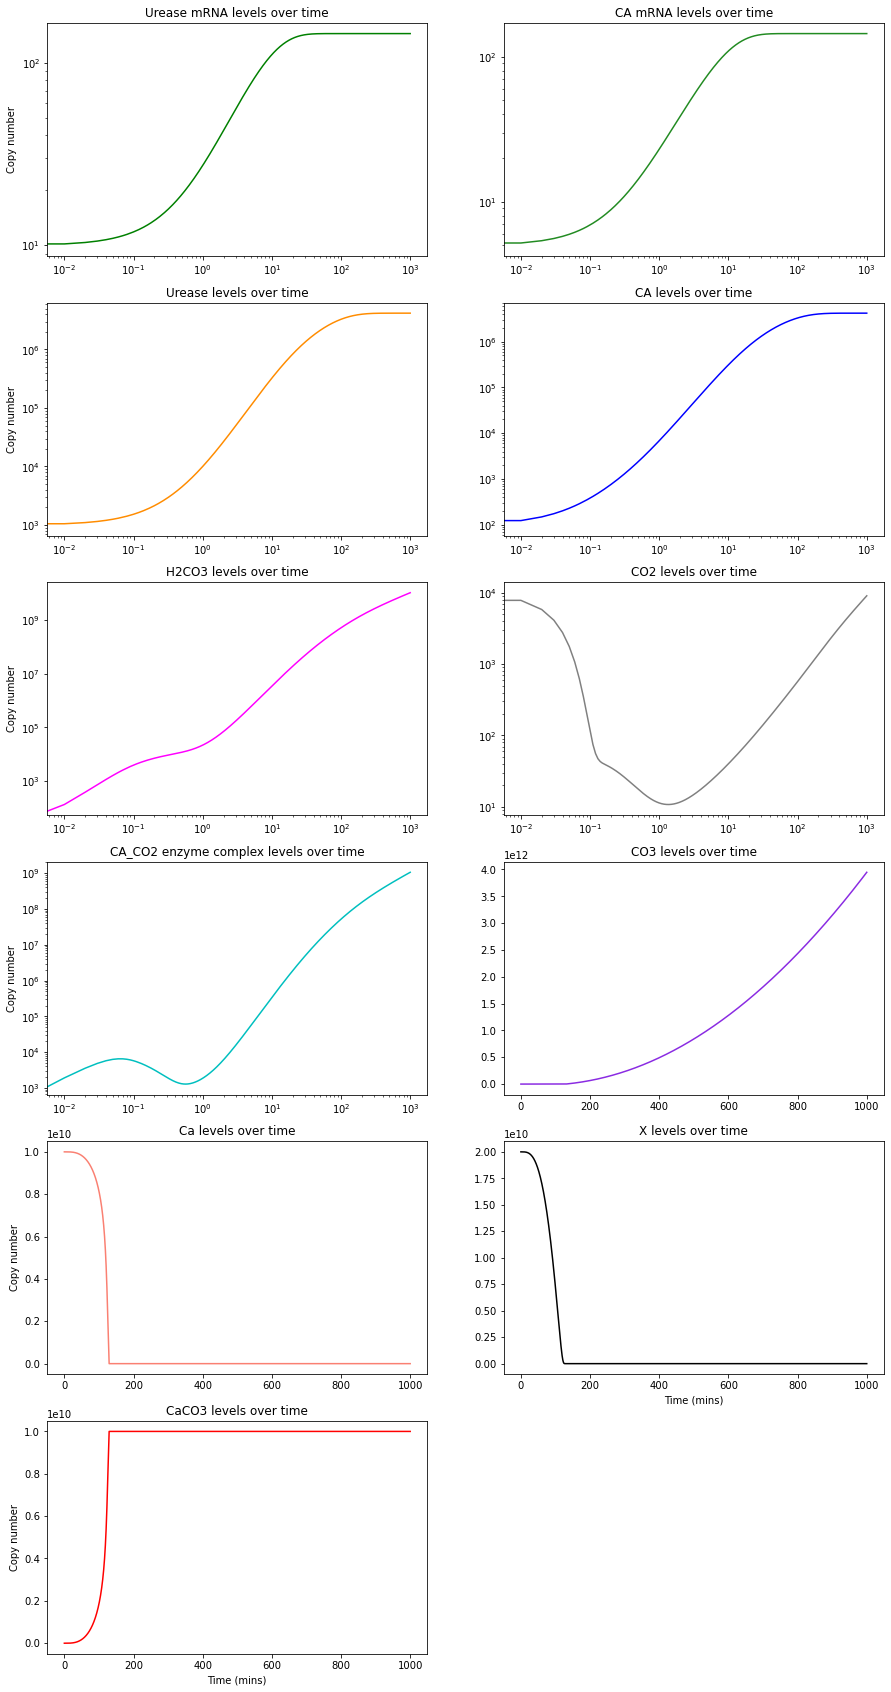

In [9]:
M1_obs = s_obs[:,0]
M2_obs = s_obs[:,1]
U_obs = s_obs[:,2]
CA_obs = s_obs[:,3]
H2CO3_obs = s_obs[:,4]
CO2_obs = s_obs[:,5]
CA_CO2_obs = s_obs[:,6]
CO3_obs = s_obs[:,7]
CaCO3_obs = s_obs[:,8]
Ca_obs = s_obs[:,9]
X_obs = s_obs[:,10]


fig1 = plt.figure(figsize=(15,30))
axes1 = fig1.add_subplot(6,2,1)
axes2 = fig1.add_subplot(6,2,2)
axes3 = fig1.add_subplot(6,2,3)
axes4 = fig1.add_subplot(6,2,4)
axes5 = fig1.add_subplot(6,2,5)
axes6 = fig1.add_subplot(6,2,6)
axes7 = fig1.add_subplot(6,2,7)
axes8 = fig1.add_subplot(6,2,8)
axes9 = fig1.add_subplot(6,2,9)
axes10 = fig1.add_subplot(6,2,10)
axes11 = fig1.add_subplot(6,2,11)

#Can play around with axes.loglog or axes.plot scales for the axes

axes1.loglog(t_obs, M1_obs, 'g-', label='Urease mRNA')
axes2.loglog(t_obs, M2_obs, color='forestgreen', label='CA mRNA')

axes3.loglog(t_obs, U_obs, color ='darkorange', label='Urease copies')
axes4.loglog(t_obs, CA_obs, 'b-', label='CA copies')

axes5.loglog(t_obs, H2CO3_obs, color='magenta', label='H2CO3')
axes6.loglog(t_obs, CO2_obs, color='grey', label='CO2')

axes7.loglog(t_obs, CA_CO2_obs, 'c-', label = 'CA and CO2 enzyme complex')
axes8.plot(t_obs, CO3_obs, color='blueviolet', label='Number of CO3  molecules')

axes9.plot(t_obs, Ca_obs, color='salmon', label='Number of Ca  molecules')
axes10.plot(t_obs, X_obs, 'k-', label='Number of X molecules')
axes11.plot(t_obs, CaCO3_obs, 'r-', label='Number of CaCO3  molecules')


axes1.set_title('Urease mRNA levels over time')
axes2.set_title('CA mRNA levels over time')
axes3.set_title('Urease levels over time')
axes4.set_title('CA levels over time')
axes5.set_title('H2CO3 levels over time')
axes6.set_title('CO2 levels over time')
axes7.set_title('CA_CO2 enzyme complex levels over time')
axes8.set_title('CO3 levels over time')
axes9.set_title('Ca levels over time')
axes10.set_title('X levels over time')
axes11.set_title('CaCO3 levels over time')

axes11.set_xlabel('Time (mins)')
axes10.set_xlabel('Time (mins)')
axes1.set_ylabel('Copy number')
axes3.set_ylabel('Copy number')
axes5.set_ylabel('Copy number')
axes7.set_ylabel('Copy number')
axes9.set_ylabel('Copy number')
axes11.set_ylabel('Copy number');

Explanation of graps:

* **Urease & CA mRNA**: Builds up and eventually reaches a steady state.
* **Urease & CA protein copies**: Build up (delay w.r.t. mRNA) and eventually reaches a steady state.
* **H2CO3**: As urease and CA act, it builds up. (*Easier to see in graph below*)
* **CO2**: At first, it's lost, i.e., gets used in the CA_CO2 complex and converts back to H2CO3. Once H2CO3 starts to increase, so does CO2, though to a lower order of magnitude. (*Easier to see in graph below*)
* **CA_CO2 enzyme complex**: Build up is slow at first because there aren't many CO2 molecules. As CO2 builds up, so does the number of enzyme complexes that form. (*Easier to see in graph below*)
* **CO3**: While there's still Ca and X, CO3 gets used up to make XCO3 and CaCO3. Once Ca and X run out, CO3 build up
* **Ca**: Gets used up to make CaCO3 and eventually runs out
* **X**: Gets used up to make XCO3 and eventually runs out
* **CaCO3**: While there's Ca, it's produced. Once Ca runs out, it can't be produced any further, but we're also assuming that it doesn't get degraded/lost, so it stays constant.

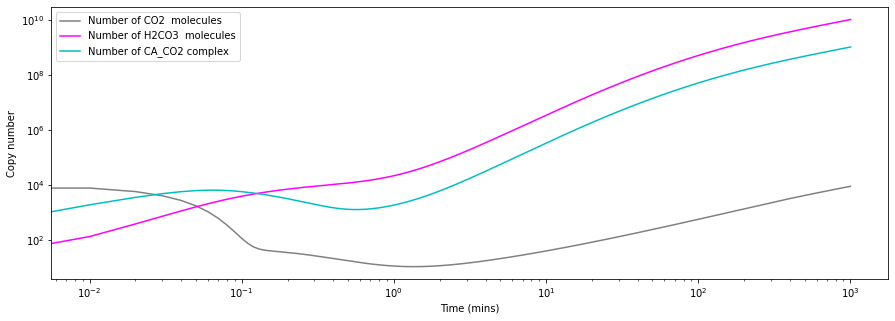

In [8]:
fig1 = plt.figure(figsize=(15,5))
axes1 = fig1.add_subplot(1,1,1)


#axes1.loglog(t_obs, M1_obs, 'g-', label='Urease mRNA')
#axes1.loglog(t_obs, M2_obs, color='forestgreen', label='CA mRNA')
axes1.loglog(t_obs, CO2_obs, color='grey', label='Number of CO2  molecules')
axes1.loglog(t_obs, H2CO3_obs, color='magenta', label='Number of H2CO3  molecules')
axes1.loglog(t_obs, CA_CO2_obs, 'c-', label='Number of CA_CO2 complex')
#axes1.plot(t_obs, CaCO3_obs, 'r-', label='Number of CaCO3  molecules')


axes1.set_xlabel('Time (mins)')
axes1.set_ylabel('Copy number')
axes1.legend();

Dip in CO2 levels means a dip in CA_CO2 complex levels. Once H2CO3 starts building up, so do the others